In [1]:
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# ЯВНО указываем корень проекта
project_root = "/home/kooduser/credit_scoring_project"

if project_root not in sys.path:
    sys.path.append(project_root)

print("project_root:", project_root)
print("последний элемент sys.path:", sys.path[-1])

from scripts.preprocess import (
    load_application_train,
    split_features_target,
    build_preprocessor,
)

pd.set_option("display.max_columns", 120)

# Путь к train-данным
train_path = os.path.join(project_root, "data", "application_train.csv")

df = load_application_train(train_path)
df.head()


project_root: /home/kooduser/credit_scoring_project
последний элемент sys.path: /home/kooduser/credit_scoring_project


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,...,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,...,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,...,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.

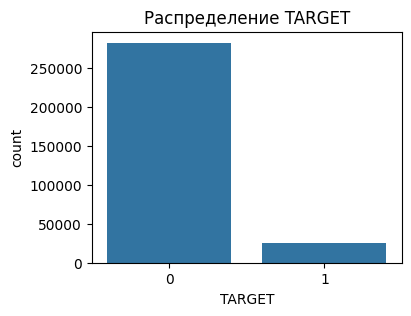

In [2]:
df["TARGET"].value_counts(normalize=True)
plt.figure(figsize=(4, 3))
sns.countplot(x=df["TARGET"])
plt.title("Распределение TARGET")
plt.show()


In [3]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

corr = df[numeric_cols].corr()["TARGET"].abs().sort_values(ascending=False)
corr.head(20)


TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
DAYS_EMPLOYED                  0.044932
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
FLOORSMAX_AVG                  0.044003
FLOORSMAX_MEDI                 0.043768
FLOORSMAX_MODE                 0.043226
DAYS_REGISTRATION              0.041975
AMT_GOODS_PRICE                0.039645
OWN_CAR_AGE                    0.037612
Name: TARGET, dtype: float64

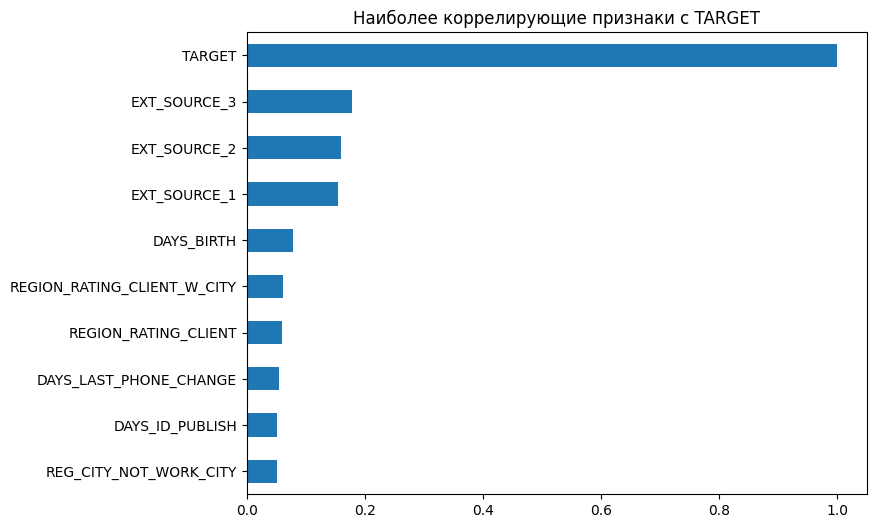

In [4]:
plt.figure(figsize=(8, 6))
corr.head(10).plot(kind="barh")
plt.title("Наиболее коррелирующие признаки с TARGET")
plt.gca().invert_yaxis()
plt.show()


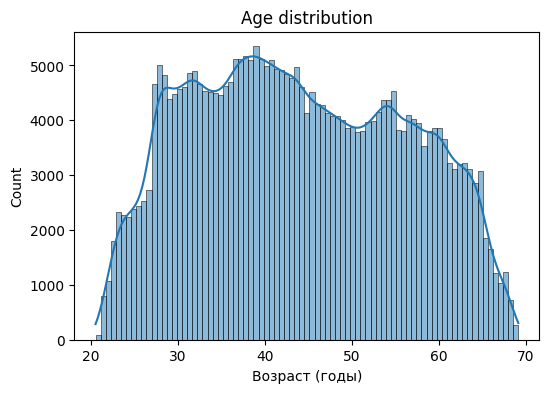

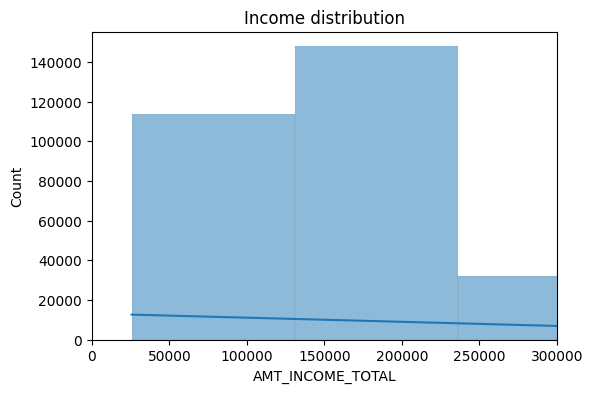

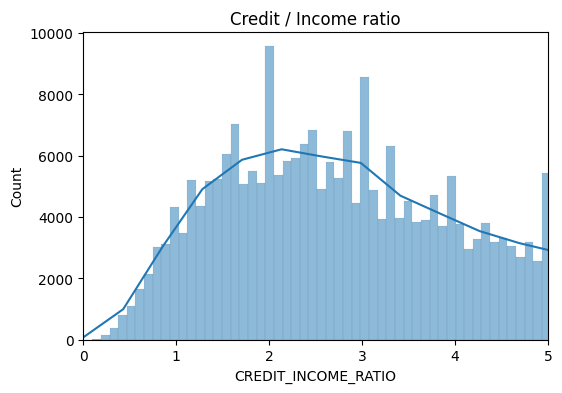

In [5]:
plt.figure(figsize=(6, 4))
sns.histplot(df["DAYS_BIRTH"] / -365, kde=True)
plt.title("Age distribution")
plt.xlabel("Возраст (годы)")
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df["AMT_INCOME_TOTAL"], kde=True)
plt.xlim(0, 300000)
plt.title("Income distribution")
plt.show()

df["CREDIT_INCOME_RATIO"] = df["AMT_CREDIT"] / df["AMT_INCOME_TOTAL"]

plt.figure(figsize=(6, 4))
sns.histplot(df["CREDIT_INCOME_RATIO"], kde=True)
plt.title("Credit / Income ratio")
plt.xlim(0, 5)
plt.show()


In [6]:
from scripts.preprocess import split_features_target, build_preprocessor

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

# Разделяем на X и y
X, y = split_features_target(df)

# Train/valid split
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Препроцессор
preprocessor = build_preprocessor(X_train)

# RandomForest (исправленный)
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    n_jobs=-1,
    random_state=42
)

# Пайплайн
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", rf_model)
    ]
)

# Обучение
clf.fit(X_train, y_train)

# Предсказание
y_valid_proba = clf.predict_proba(X_valid)[:, 1]

# AUC
auc = roc_auc_score(y_valid, y_valid_proba)
print(f"AUC на валидации (ноутбук): {auc:.4f}")


AUC на валидации (ноутбук): 0.7358
